# Variability

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_path = '/data_volume/memento/sciplex/'

In [5]:
ct = 'A549'

In [6]:
adata = sc.read(data_path + 'h5ad/{}.h5ad'.format(ct))

### Combine DV results for each drug target

In [7]:
target_list = [
    'Aurora Kinase',
    'DNA/RNA Synthesis',
    'HDAC',
    'Histone Methyltransferase',
    'JAK',
    'PARP',
    'Sirtuin']

target_to_dir = {
    'Aurora Kinase':'aurora',
    'DNA/RNA Synthesis':'dna_rna',
    'HDAC':'hdac',
    'Histone Methyltransferase':'histmeth',
    'JAK':'jak',
    'PARP':'parp',
    'Sirtuin':'sirt'}

In [8]:
target = 'HDAC'

In [72]:
def get_combined_1d_result(target, col='dv_pval'):
    
    drug_counts = adata.obs.query('target == "{}"'.format(target)).product_name.value_counts()
    drug_list = drug_counts[drug_counts > 0].index.tolist()

    result = pd.DataFrame()
    start = True
    for drug1, drug2 in itertools.combinations(drug_list,2):

        subset = sc.read(data_path + '{}/{}_vs_{}_10000.h5ad'.format(target_to_dir[target], drug1, drug2))
        df = memento.get_1d_ht_result(subset)
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        if start:

            result['gene'] = df['gene']
            result['{}_{}'.format(drug1, drug2)] = df[col]
            start = False
        else:
            result = result.merge(df[['gene', col]].rename(columns={col:'{}_{}'.format(drug1, drug2)}), how='outer')
            
#         result['num_sig'] = (result.iloc[:, 1:] < 0.1).sum()
            
#     combined_pvals = []
#     for g in result.gene:
#         pvalues = result.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
#         chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
#         combined_pvals.append((g, chisq, pv))

#     combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
#     combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])
    
    return result

In [73]:
a = get_combined_1d_result(target, col='dv_fdr')

In [74]:
a.head(5)

,gene,TMP195_MC1568,TMP195_Divalproex Sodium,TMP195_Tucidinostat (Chidamide),TMP195_ITSA-1 (ITSA1),TMP195_PCI-34051,TMP195_Mocetinostat (MGCD0103),TMP195_Belinostat (PXD101),TMP195_Abexinostat (PCI-24781),TMP195_Pracinostat (SB939),TMP195_Dacinostat (LAQ824),TMP195_Panobinostat (LBH589),TMP195_Sodium Phenylbutyrate,TMP195_Droxinostat,TMP195_Tubastatin A HCl,TMP195_Entinostat (MS-275),TMP195_Tacedinaline (CI994),TMP195_Quisinostat (JNJ-26481585) 2HCl,TMP195_Trichostatin A (TSA),TMP195_M344,TMP195_Resminostat,TMP195_Givinostat (ITF2357),TMP195_AR-42,MC1568_Divalproex Sodium,MC1568_Tucidinostat (Chidamide),MC1568_ITSA-1 (ITSA1),MC1568_PCI-34051,MC1568_Mocetinostat (MGCD0103),MC1568_Belinostat (PXD101),MC1568_Abexinostat (PCI-24781),MC1568_Pracinostat (SB939),MC1568_Dacinostat (LAQ824),MC1568_Panobinostat (LBH589),MC1568_Sodium Phenylbutyrate,MC1568_Droxinostat,MC1568_Tubastatin A HCl,MC1568_Entinostat (MS-275),MC1568_Tacedinaline (CI994),MC1568_Quisinostat (JNJ-26481585) 2HCl,MC1568_Trichostatin A (TSA),MC1568_M344,MC1568_Resminostat,MC1568_Givinostat (ITF2357),MC1568_AR-42,Divalproex Sodium_Tucidinostat (Chidamide),Divalproex Sodium_ITSA-1 (ITSA1),Divalproex Sodium_PCI-34051,Divalproex Sodium_Mocetinostat (MGCD0103),Divalproex Sodium_Belinostat (PXD101),Divalproex Sodium_Abexinostat (PCI-24781),Divalproex Sodium_Pracinostat (SB939),Divalproex Sodium_Dacinostat (LAQ824),Divalproex Sodium_Panobinostat (LBH589),Divalproex Sodium_Sodium Phenylbutyrate,Divalproex Sodium_Droxinostat,Divalproex Sodium_Tubastatin A HCl,Divalproex Sodium_Entinostat (MS-275),Divalproex Sodium_Tacedinaline (CI994),Divalproex Sodium_Quisinostat (JNJ-26481585) 2HCl,Divalproex Sodium_Trichostatin A (TSA),Divalproex Sodium_M344,Divalproex Sodium_Resminostat,Divalproex Sodium_Givinostat (ITF2357),Divalproex Sodium_AR-42,Tucidinostat (Chidamide)_ITSA-1 (ITSA1),Tucidinostat (Chidamide)_PCI-34051,Tucidinostat (Chidamide)_Mocetinostat (MGCD0103),Tucidinostat (Chidamide)_Belinostat (PXD101),Tucidinostat (Chidamide)_Abexinostat (PCI-24781),Tucidinostat (Chidamide)_Pracinostat (SB939),Tucidinostat (Chidamide)_Dacinostat (LAQ824),Tucidinostat (Chidamide)_Panobinostat (LBH589),Tucidinostat (Chidamide)_Sodium Phenylbutyrate,Tucidinostat (Chidamide)_Droxinostat,Tucidinostat (Chidamide)_Tubastatin A HCl,Tucidinostat (Chidamide)_Entinostat (MS-275),Tucidinostat (Chidamide)_Tacedinaline (CI994),Tucidinostat (Chidamide)_Quisinostat (JNJ-26481585) 2HCl,Tucidinostat (Chidamide)_Trichostatin A (TSA),Tucidinostat (Chidamide)_M344,Tucidinostat (Chidamide)_Resminostat,Tucidinostat (Chidamide)_Givinostat (ITF2357),Tucidinostat (Chidamide)_AR-42,ITSA-1 (ITSA1)_PCI-34051,ITSA-1 (ITSA1)_Mocetinostat (MGCD0103),ITSA-1 (ITSA1)_Belinostat (PXD101),ITSA-1 (ITSA1)_Abexinostat (PCI-24781),ITSA-1 (ITSA1)_Pracinostat (SB939),ITSA-1 (ITSA1)_Dacinostat (LAQ824),ITSA-1 (ITSA1)_Panobinostat (LBH589),ITSA-1 (ITSA1)_Sodium Phenylbutyrate,ITSA-1 (ITSA1)_Droxinostat,ITSA-1 (ITSA1)_Tubastatin A HCl,ITSA-1 (ITSA1)_Entinostat (MS-275),ITSA-1 (ITSA1)_Tacedinaline (CI994),ITSA-1 (ITSA1)_Quisinostat (JNJ-26481585) 2HCl,ITSA-1 (ITSA1)_Trichostatin A (TSA),ITSA-1 (ITSA1)_M344,ITSA-1 (ITSA1)_Resminostat,ITSA-1 (ITSA1)_Givinostat (ITF2357),ITSA-1 (ITSA1)_AR-42,PCI-34051_Mocetinostat (MGCD0103),PCI-34051_Belinostat (PXD101),PCI-34051_Abexinostat (PCI-24781),PCI-34051_Pracinostat (SB939),PCI-34051_Dacinostat (LAQ824),PCI-34051_Panobinostat (LBH589),PCI-34051_Sodium Phenylbutyrate,PCI-34051_Droxinostat,PCI-34051_Tubastatin A HCl,PCI-34051_Entinostat (MS-275),PCI-34051_Tacedinaline (CI994),PCI-34051_Quisinostat (JNJ-26481585) 2HCl,PCI-34051_Trichostatin A (TSA),PCI-34051_M344,PCI-34051_Resminostat,PCI-34051_Givinostat (ITF2357),PCI-34051_AR-42,Mocetinostat (MGCD0103)_Belinostat (PXD101),Mocetinostat (MGCD0103)_Abexinostat (PCI-24781),Mocetinostat (MGCD0103)_Pracinostat (SB939),Mocetinostat (MGCD0103)_Dacinostat (LAQ824),Mocetinostat (MGCD0103)_Panobinostat (LBH589),Mocetinostat (MGCD0103)_Sodium Phenylbutyrate,Moce

In [75]:
(a.iloc[:, 1:] < 0.2).sum().max()

0

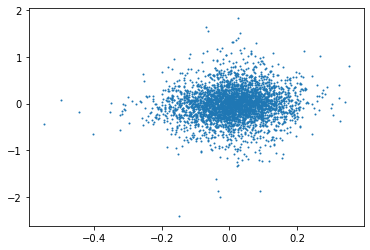

In [56]:
plt.scatter(a['de_coef'], a['dv_coef'], s=1)

In [53]:
a

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,CFH,0.091743,0.057143,0.113789,-0.578789,0.281851,0.044196
1,GCLC,0.069154,0.047174,0.142386,0.231978,0.153625,0.130487
2,ANKIB1,0.020853,0.046015,0.655434,-0.105519,0.421655,0.780122
3,KRIT1,0.036116,0.071774,0.616638,0.095524,0.244410,0.694631
4,HECW1,-0.088353,0.053908,0.101190,0.390213,0.311092,0.184582
...,...,...,...,...,...,...,...
3615,MYO19,0.038165,0.061187,0.532247,0.495764,0.315654,0.103490
3616,GGNBP2,0.043924,0.056878,0.447355,-0.391568,0.375897,0.277772
3617,ACACA,-0.055774,0.031219,0.077692,0.160280,0.130831,0.214079
3618,IQCJ-SCHIP1,0.109833,0.081745,0.177382,-0.112937,0.431678,0.768023


In [39]:
result, combined_pvals = get_combined_1d_result(target, col='dv_pval')

### GSEA + Enrichr

In [40]:
import gseapy as gp
from gseapy.plot import gseaplot


In [41]:
combined_pvals.query('fdr < 0.01').shape

(1050, 4)

In [46]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.005').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [47]:
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,28/171,5.288169e-08,0.000200,0,0,3.679047,61.643208,SMG1;RPL32;RPL34;PARN;CASC3;RPL10A;RPL6;RPL7;S...
1,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",21/113,2.762529e-07,0.000521,0,0,4.270673,64.495482,UPF2;SMG1;RPL32;RPS7;RPL34;RPL23;RPS5;CASC3;RP...
2,GO_Biological_Process_2021,gene expression (GO:0010467),42/356,4.945169e-07,0.000622,0,0,2.525697,36.672322,POM121;SMG1;RPL32;RPL34;CASC3;RPL10A;BICD1;RPL...
3,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,87/1025,2.836706e-06,0.002677,0,0,1.773571,22.653589,PRKCSH;UBE2D2;NGLY1;PRKAG1;PTEN;KEAP1;CHM;MIA3...
4,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),17/93,4.693658e-06,0.003544,0,0,4.172053,51.188160,EIF4A1;RPL32;RPS7;RPL34;RPL23;RPS5;RPL10A;RPL6...
5,GO_Biological_Process_2021,negative regulation of protein modification pr...,15/81,1.430557e-05,0.009001,0,0,4.232871,47.217086,G6PD;PRKAA1;CRTAP;TGFB1;YWHAB;NTRK3;PTEN;CDYL;...
6,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,16/94,2.263429e-05,0.012206,0,0,3.821777,40.877899,RPL32;RPS7;RPL34;RPL23;RPS5;SSR2;RPL10A;RPL6;R...
7,GO_Biological_Process_2021,organelle assembly (GO:0070925),42/425,4.193574e-05,0.017905,0,0,2.063017,20.793919,DDX6;ASAP1;AMBRA1;FNBP1L;LIMD1;BICD1;CDC14B;PC...
8,GO_Biological_Process_2021,phosphorylation (GO:0016310),40/400,4.874394e-05,0.017905,0,0,2.088664,20.738202,PRKAA1;PANK2;CAMK2D;ROCK1;PRKAG1;PIK3CB;LIMD1;...
9,GO_Biological_Process_2021,protein stabilization (GO:0050821),23/179,4.938509e-05,0.017905,0,0,2.754577,27.314005,CCT2;CRTAP;HSP90AA1;COG7;HIP1;RPS7;RPL23;PTGES...


In [48]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [49]:
df = enr.results.sort_values('Odds Ratio', ascending=False)
df[df['Adjusted P-value'] < 0.1].head(30)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
39,WikiPathways_2019_Human,Somatroph axis (GH) and its relationship to di...,3/6,0.002560,0.024962,0,0,18.096466,107.993773,PTEN;SIRT1;IGF1R
29,WikiPathways_2019_Human,Leptin and adiponectin WP3934,4/10,0.001229,0.015979,0,0,12.073932,80.912494,CPT1A;PRKAA1;PRKAG1;ACACA
46,WikiPathways_2019_Human,HIF1A and PPARG regulation of glycolysis WP2456,3/8,0.006622,0.054281,0,0,10.856734,54.472477,TPI1;PPARG;GAPDH
55,WikiPathways_2019_Human,Cytosine methylation WP3585,3/9,0.009548,0.064566,0,0,9.046800,42.080520,IDH1;TDG;TET3
27,WikiPathways_2019_Human,SREBF and miR33 in cholesterol and lipid homeo...,5/16,0.001061,0.014782,0,0,8.237930,56.415759,PRKAA1;HMGCS1;SIRT1;MED15;LDLR
26,WikiPathways_2019_Human,Cori Cycle WP1946,5/16,0.001061,0.014782,0,0,8.237930,56.415759,G6PD;TPI1;GAPDH;PFKP;HK1
17,WikiPathways_2019_Human,Hereditary leiomyomatosis and renal cell carci...,6/20,0.000423,0.009175,0,0,7.773399,60.376130,PRKAA1;PRKAG1;KEAP1;ACACB;ACACA;NFE2L2
35,WikiPathways_2019_Human,TGF-B Signaling in Thyroid Cells for Epithelia...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,SMAD2;TGFB1;CDH1;ID1;MAPK1
34,WikiPathways_2019_Human,Inhibition of exosome biogenesis and secretion...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,PDCD6IP;RRAS2;MAPK1;BRAF;RAB5A
72,WikiPathways_2019_Human,"NAD metabolism, sirtuins and aging WP3630",3/11,0.017336,0.091587,0,0,6.784384,27.510354,NAMPT;PPARG;SIRT1
